# Bibliotecas

In [ ]:
# ! pip install statsmodels -U
# !pip install pmdarima
# ! pip install ptitprince

In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import ndiffs, auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import ptitprince as pt

# Dataset

In [3]:
data_dir = '/content/drive/MyDrive/Datasets/NASA Acoustics and Vibration Database/2nd_test/2nd_test'
df_rolamento = pd.DataFrame()

for filename in os.listdir(data_dir):
    dataset = pd.read_csv(os.path.join(data_dir, filename), sep='\t')
    dataset_mean_abs = np.array(dataset.abs().mean())
    dataset_mean_abs = pd.DataFrame(dataset_mean_abs.reshape(1,4))
    dataset_mean_abs.index = [filename]
    df_rolamento = df_rolamento.append(dataset_mean_abs)

df_rolamento.columns = ['bearing_1','bearing_2','bearing_3','bearing_4']

## Ajuste do dataset

In [4]:
df_rolamento = pd.DataFrame(df_rolamento['bearing_1'])

df_rolamento.index = pd.to_datetime(df_rolamento.index,
                                    format='%Y.%m.%d.%H.%M.%S').sort_values()

In [5]:
df_rolamento

,bearing_1
2004-02-12 10:32:39,0.061630
2004-02-12 10:42:39,0.058333
2004-02-12 10:52:39,0.061231
2004-02-12 11:02:39,0.058995
2004-02-12 11:12:39,0.062599
...,...
2004-02-19 05:42:39,0.001857
2004-02-19 05:52:39,0.351952
2004-02-19 06:02:39,0.294231
2004-02-19 06:12:39,0.001168


In [6]:
pico_1 = df_rolamento.loc[pd.to_datetime('2004-02-19 04:12:39')][0].round(2)

pico_1

0.42

In [7]:
pico_2 = df_rolamento.loc[pd.to_datetime('2004-02-19 05:32:39')][0].round(2)

pico_2

0.45

## Limite superior df_rolamento

### 3 sigma

In [8]:
media = df_rolamento.mean()[0]

media

0.08090527536238788

In [9]:
desv_pad = df_rolamento.std()[0]

desv_pad

0.04017148860617038

In [10]:
lim_sup_df_rolamento = 3 * desv_pad + media

lim_sup_df_rolamento

0.20141974118089903

### Boxplot

In [11]:
df_rolamento.describe()

,bearing_1
count,984.000000
mean,0.080905
std,0.040171
min,0.001168
25%,0.060765
50%,0.062007
75%,0.083223
max,0.453335


In [12]:
primeiro_q = df_rolamento.describe().loc['25%'][0]

terceiro_q = df_rolamento.describe().loc['75%'][0]

limite_superior_df_rolamento = terceiro_q + 1.5 * (terceiro_q - primeiro_q)

limite_superior_df_rolamento

0.11690946213194005

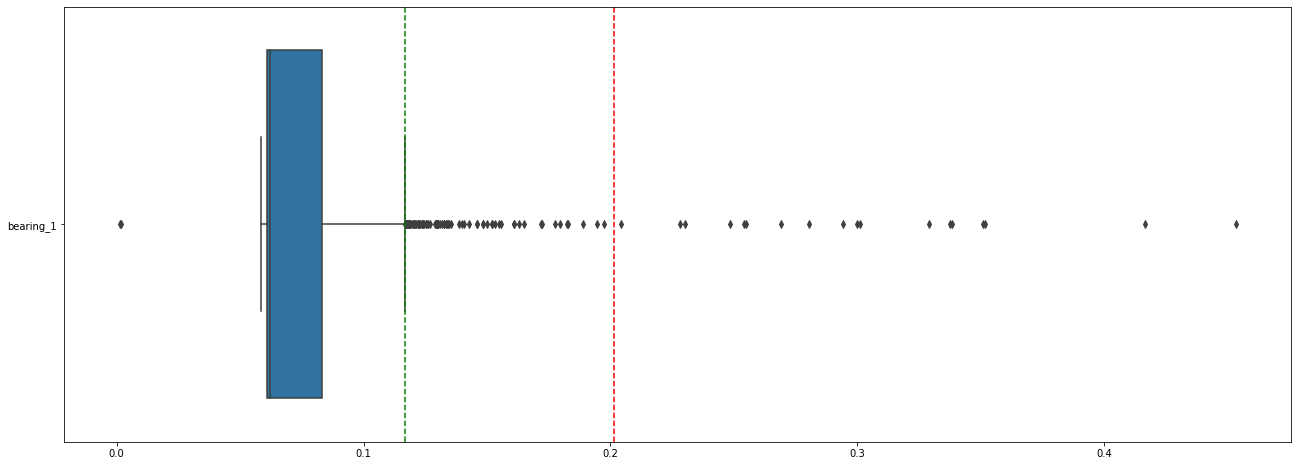

In [44]:
ax = sns.boxplot(data=df_rolamento, orient='h')

ax.axvline(lim_sup_df_rolamento, color='r', linestyle='--')

ax.axvline(limite_superior_df_rolamento, color='green', linestyle='--')

ax.figure.set_size_inches(22,8)

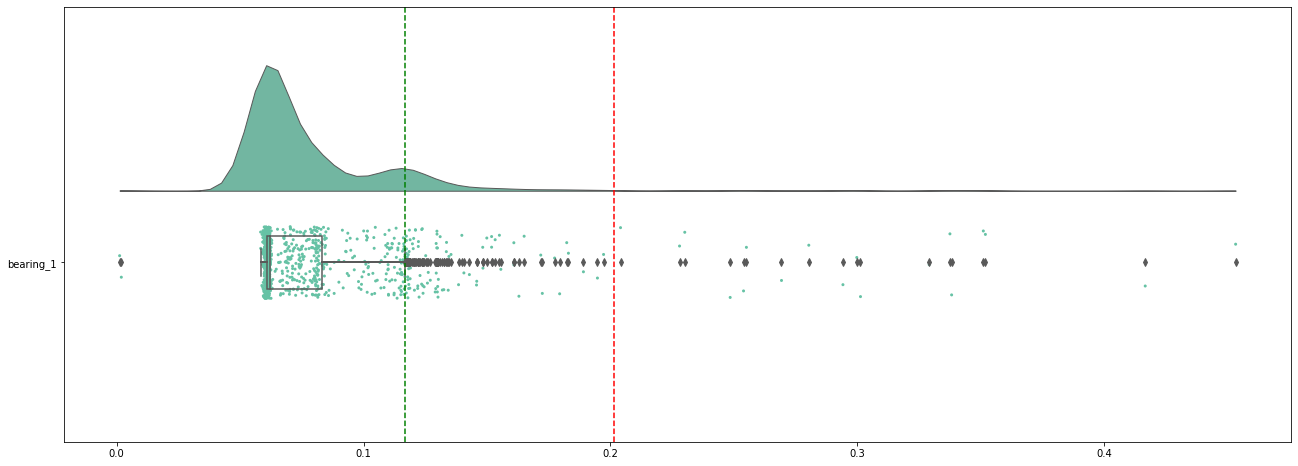

In [14]:
ax = pt.RainCloud(data=df_rolamento,
                  orient='h')

ax.axvline(lim_sup_df_rolamento, color='r', linestyle='--')

ax.axvline(limite_superior_df_rolamento, color='green', linestyle='--')

ax.figure.set_size_inches(22,8)

## Dataset pré-falha

In [15]:
df = df_rolamento.loc[:'2004-02-19 03:32:39'].copy()

df

,bearing_1
2004-02-12 10:32:39,0.061630
2004-02-12 10:42:39,0.058333
2004-02-12 10:52:39,0.061231
2004-02-12 11:02:39,0.058995
2004-02-12 11:12:39,0.062599
...,...
2004-02-19 02:52:39,0.139824
2004-02-19 03:02:39,0.179450
2004-02-19 03:12:39,0.153324
2004-02-19 03:22:39,0.228029


### 3 sigma

In [16]:
media_df = df.mean()[0]

media_df

0.07738040915927043

In [17]:
desv_pad_df = df.std()[0]

desv_pad_df

0.026222698066080404

In [18]:
lim_sup_df = 3 * desv_pad_df + media_df

lim_sup_df

0.15604850335751164

### Boxplot

In [19]:
df.describe()

,bearing_1
count,967.000000
mean,0.077380
std,0.026223
min,0.058293
25%,0.060757
50%,0.061936
75%,0.081865
max,0.230144


In [20]:
primeiro_q = df.describe().loc['25%'][0]

terceiro_q = df.describe().loc['75%'][0]

limite_superior_df = terceiro_q + 1.5 * (terceiro_q - primeiro_q)

limite_superior_df

0.11352841935641389

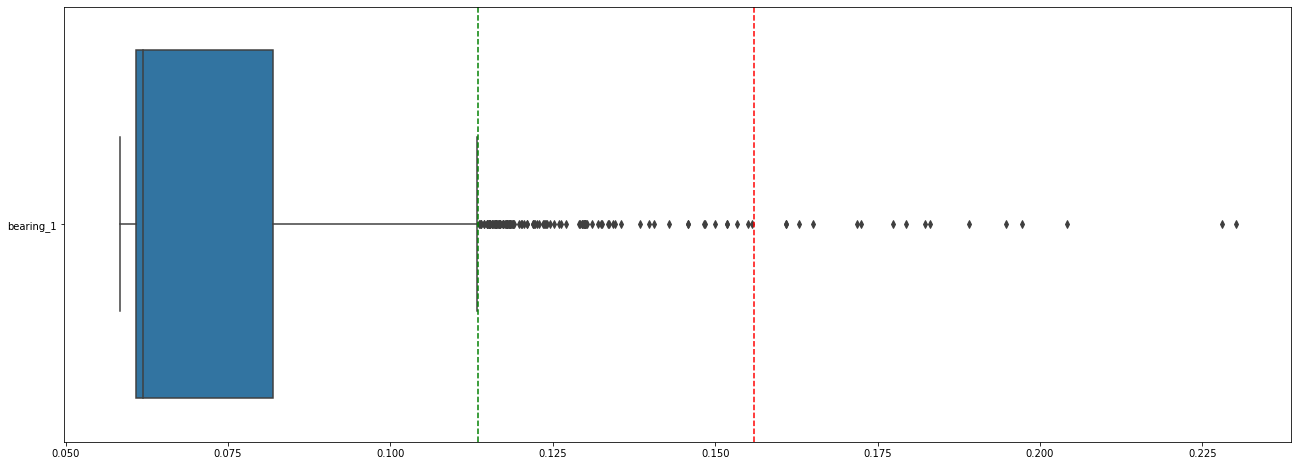

In [21]:
ax = sns.boxplot(data=df, orient='h')

ax.axvline(lim_sup_df, color='r', linestyle='--')

ax.axvline(limite_superior_df, color='green', linestyle='--')

ax.figure.set_size_inches(22,8)

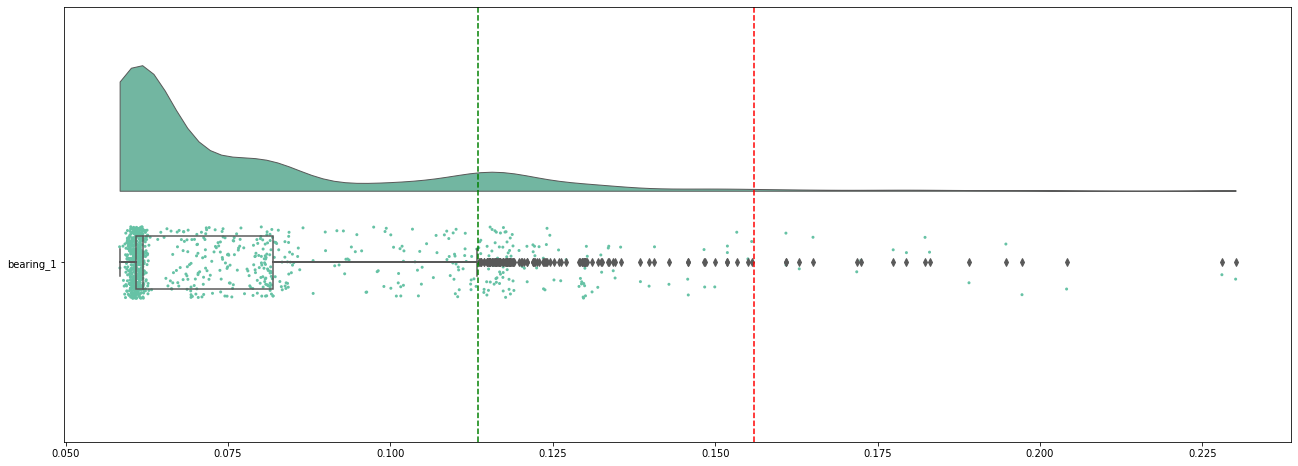

In [22]:
ax = pt.RainCloud(data=df,
                  orient='h')

ax.axvline(lim_sup_df, color='r', linestyle='--')

ax.axvline(limite_superior_df, color='green', linestyle='--')

ax.figure.set_size_inches(22,8)

# Teste de estacionariedade

## Teste de Dickey-Fuller

In [23]:
stat_t = adfuller(df.dropna())[0]
p_valor = adfuller(df.dropna())[1]

valor_critico_1 = adfuller(df.dropna())[4].get('1%')
valor_critico_5 = adfuller(df.dropna())[4].get('5%')
valor_critico_10 = adfuller(df.dropna())[4].get('10%')

significancia= 0.05
# Se a significância for 1% ou 10% é necessário
# alterar a condicional no if

if valor_critico_5 <= stat_t and significancia <= p_valor:
    print('Hipótese nula aceita'
          '\nSérie temporal não estacionária')
else:
    print('Hipótese nula rejeitada'
          '\nSérie temporal estacionária')

Hipótese nula aceita
Série temporal não estacionária


## Autocorrelação

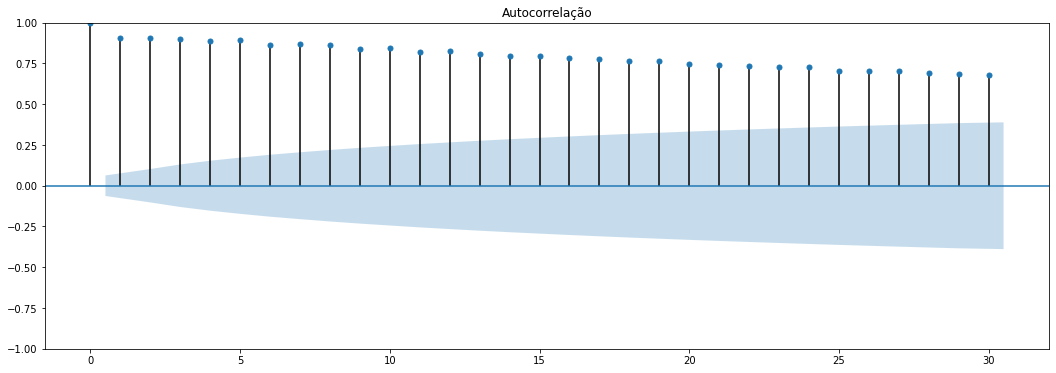

In [24]:
autocorr = plot_acf(df, title='Autocorrelação')
autocorr.set_figheight(6)
autocorr.set_figwidth(18)
plt.show()

## Autocorrelação parcial

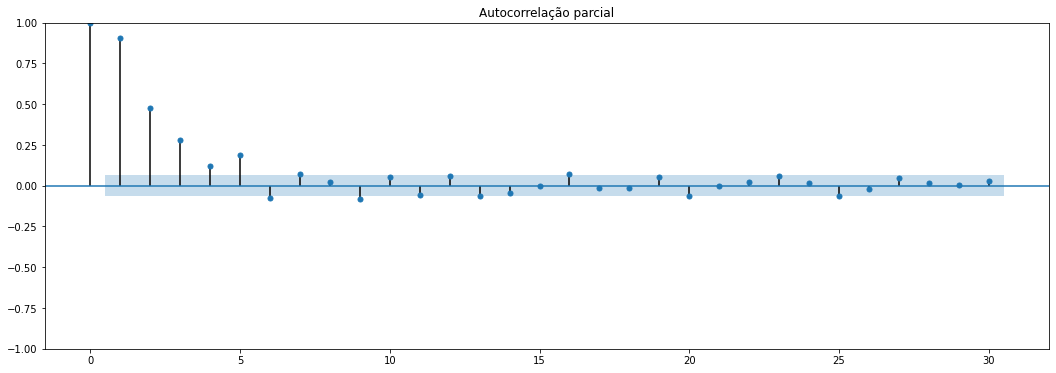

In [25]:
autocorr_parc = plot_pacf(df,
                          title='Autocorrelação parcial',
                          method='ywm')
autocorr_parc.set_figheight(6)
autocorr_parc.set_figwidth(18)
plt.show()

## Diferenciação

In [26]:
ndiffs(df, test='adf')

1

# ARIMA

## Parâmetros p, d, q

In [27]:
auto_arima = auto_arima(df)

auto_arima

ARIMA(order=(2, 1, 5), scoring_args={}, suppress_warnings=True)

In [28]:
modelo = ARIMA(endog=df,
               order=(2, 1, 5),
               freq='10min')

results = modelo.fit()

# print(results.summary())

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)


## Análise dos resíduos

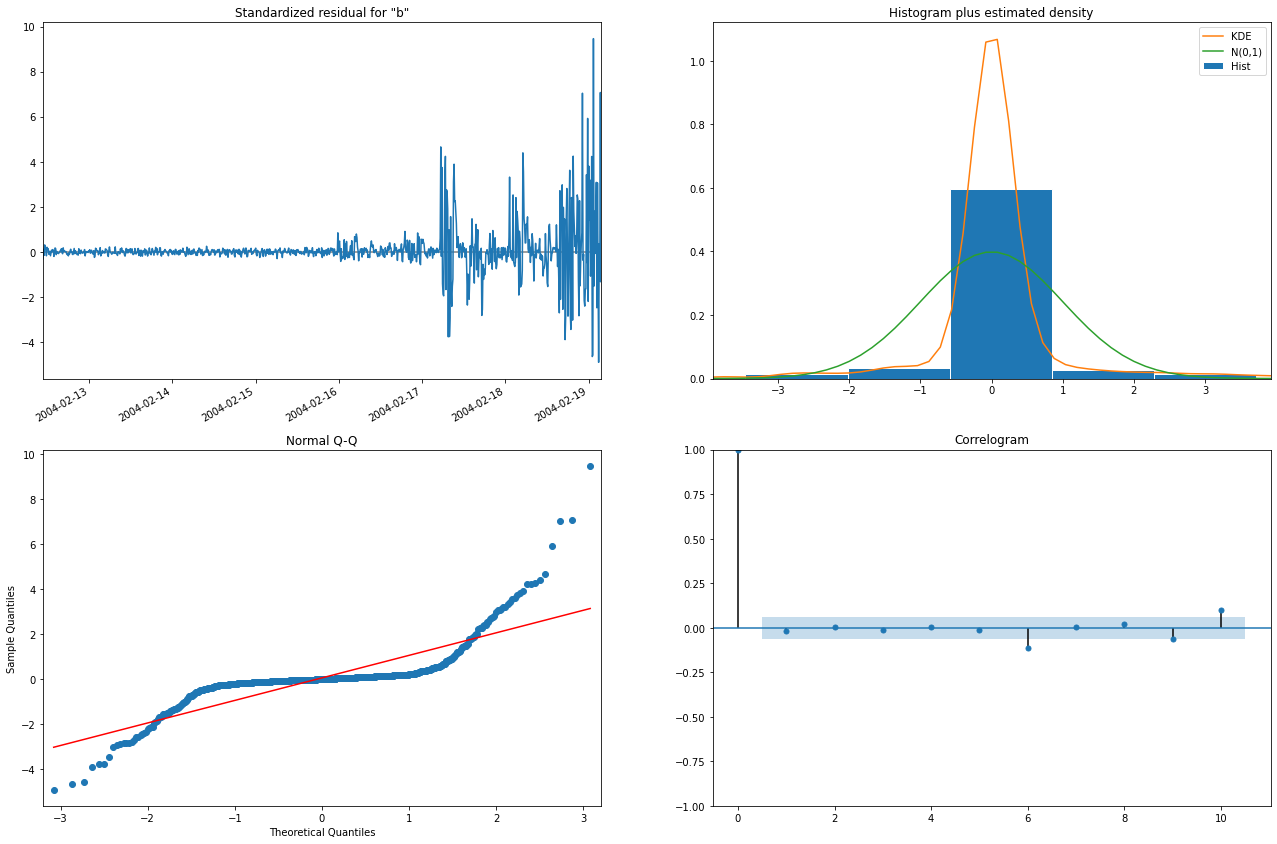

In [29]:
results.plot_diagnostics(figsize=(22,16));

# Previsão de valores



## Treino e teste

In [30]:
tam_treino = int(round(len(df) * 0.7, 0))

In [31]:
train = df.iloc[:tam_treino]

test = df.iloc[tam_treino:]

## Interpolação

#### Modelo de previsão

In [32]:
pred = results.get_prediction(start=test.index[0],
                              dynamic=False)

### Intervalo de confiança

In [33]:
pred_ic = pred.conf_int()

### Análise gráfica

Text(2004-02-19 06:02:39, 0.45, 'pico 2 ➜ 0.45')

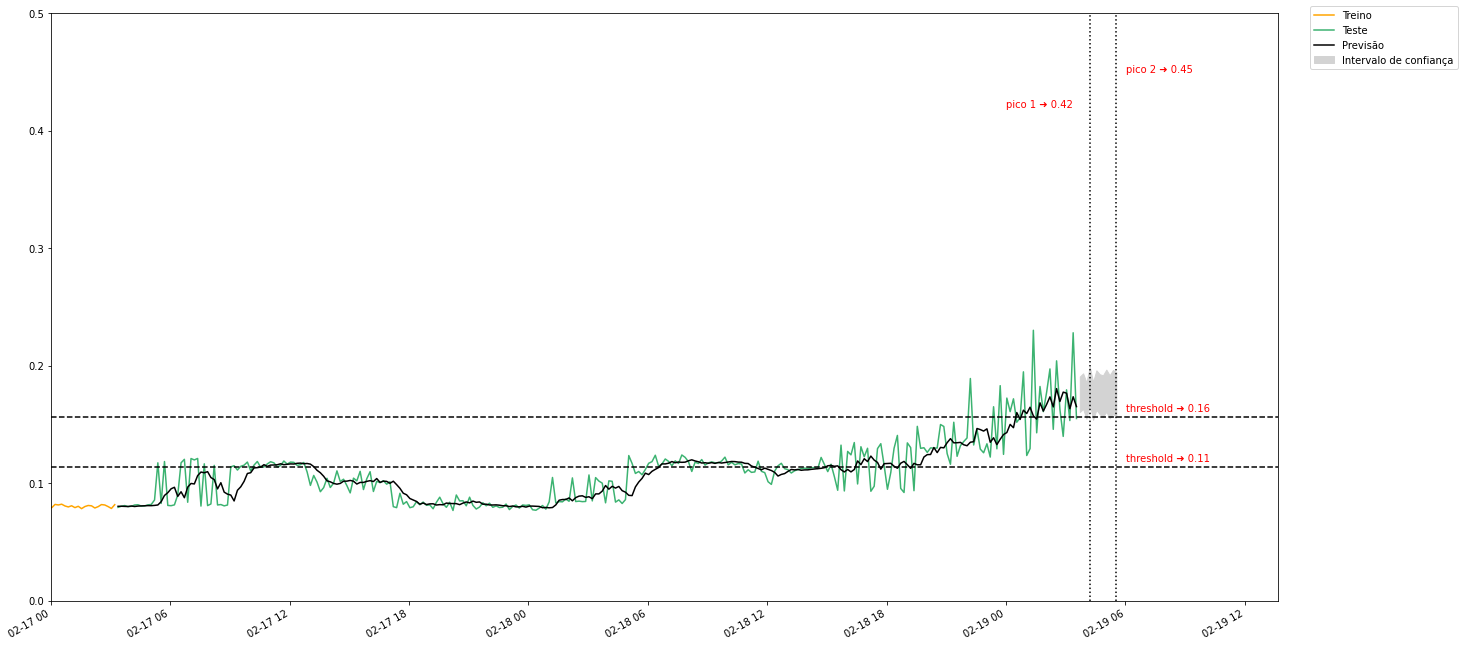

In [46]:
ax = train.plot(color='orange')

test.plot(ax=ax, color='mediumseagreen')

pred.predicted_mean.plot(ax=ax, color='k')

ax.fill_between(pred_ic.index,
                pred_ic.iloc[:, 0],
                pred_ic.iloc[:, 1],
                color='lightgrey')

ax.figure.set_size_inches(22,12)
ax.set_xlabel(None)
ax.legend(labels=['Treino',
                  'Teste',
                  'Previsão',
                  'Intervalo de confiança'],
                   bbox_to_anchor=(1.15, 1.02))

ax.set_xlim(pd.to_datetime('2004-02-17'))
ax.set_ylim(0, 0.5)

ax.axvline('2004-02-19 04:12:39',
           color='black',
           linestyle=':')

ax.axvline('2004-02-19 05:32:39',
           color='black',
           linestyle=':')

ax.axhline(lim_sup_df,
           color='black',
           linestyle='--')

ax.axhline(limite_superior_df,
           color='black',
           linestyle='--')

ax.annotate(s='threshold ➜ ' + str(lim_sup_df.round(2)),
            xy=(pd.to_datetime('2004-02-19'), lim_sup_df),
            xytext=(pd.to_datetime('2004-02-19 06:02:39'), lim_sup_df + 0.005),
            color='r')

ax.annotate(s='threshold ➜ ' + str(limite_superior_df.round(2)),
            xy=(pd.to_datetime('2004-02-19'), limite_superior_df),
            xytext=(pd.to_datetime('2004-02-19 06:02:39'), limite_superior_df + 0.005),
            color='r')

ax.annotate(s='pico 1 ➜ ' + str(pico_1),
            xy=(pd.to_datetime('2004-02-19'), pico_1),
            xytext=(pd.to_datetime('2004-02-19'), pico_1),
            color='r')

ax.annotate(s='pico 2 ➜ ' + str(pico_2),
            xy=(pd.to_datetime('2004-02-19'), pico_2),
            xytext=(pd.to_datetime('2004-02-19 06:02:39'), pico_2),
            color='r')

In [35]:
df_pred = df.copy()

df_pred['pred'] = pred.predicted_mean

In [36]:
df_pred = df_pred.query('pred >= @lim_sup_df').copy()

df_pred

,bearing_1,pred
2004-02-19 00:32:39,0.151880,0.160115
2004-02-19 00:52:39,0.194766,0.162149
2004-02-19 01:02:39,0.123570,0.159274
2004-02-19 01:12:39,0.129449,0.164640
2004-02-19 01:22:39,0.230144,0.157279
2004-02-19 01:42:39,0.182316,0.168402
2004-02-19 01:52:39,0.160895,0.161392
2004-02-19 02:02:39,0.177413,0.167073
2004-02-19 02:12:39,0.197247,0.173463
2004-02-19 02:22:39,0.145859,0.164918


### Acurácia do modelo

#### Raiz do erro quadrático médio

In [37]:
from math import sqrt

rmse = sqrt(mean_squared_error(test,
                         pred.predicted_mean))

rmse

0.013917307667023707

#### Coeficiente de determinação (r²)

In [38]:
r_squared = r2_score(test,
                     pred.predicted_mean)

r_squared

0.7295847773610735

#### Erro médio absoluto

In [39]:
mae = mean_absolute_error(test,
                          pred.predicted_mean)

mae

0.009094364674887943

## Extrapolação

In [40]:
pred_uc = results.get_forecast(steps=12) # Em cada passo deve ser considerado 10 min

### Intervalo de confiança

In [41]:
pred_ic = pred_uc.conf_int()

### Análise gráfica

Text(2004-02-19 06:02:39, 0.45, 'pico 2 ➜ 0.45')

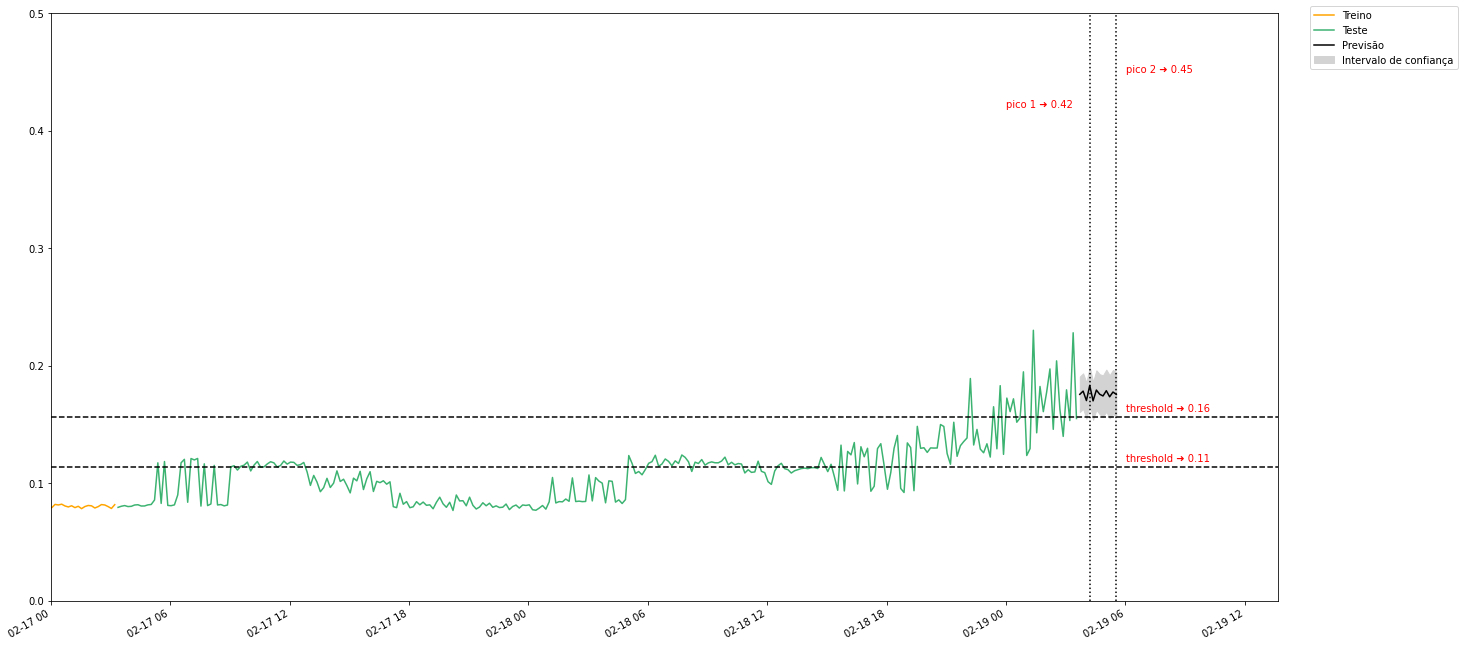

In [42]:
fig, ax = plt.subplots(figsize=(22, 12))

train.plot(ax=ax, color='orange')

test.plot(ax=ax, color='mediumseagreen')

pred_uc.predicted_mean.plot(ax=ax, color='k')

ax.fill_between(pred_ic.index,
                pred_ic.iloc[:, 0],
                pred_ic.iloc[:, 1],
                color='lightgrey')

ax.legend(labels=['Treino', 'Teste', 'Previsão', 'Intervalo de confiança'],
          bbox_to_anchor=(1.15, 1.02))

ax.set_xlim(pd.to_datetime('2004-02-17'))
ax.set_ylim(0, 0.5)

ax.axvline('2004-02-19 04:12:39',
           color='black',
           linestyle=':')

ax.axvline('2004-02-19 05:32:39',
           color='black',
           linestyle=':')

ax.axhline(lim_sup_df,
           color='black',
           linestyle='--')

ax.axhline(limite_superior_df,
           color='black',
           linestyle='--')

ax.annotate(s='threshold ➜ ' + str(lim_sup_df.round(2)),
            xy=(pd.to_datetime('2004-02-19'), lim_sup_df),
            xytext=(pd.to_datetime('2004-02-19 06:02:39'), lim_sup_df + 0.005),
            color='r')

ax.annotate(s='threshold ➜ ' + str(limite_superior_df.round(2)),
            xy=(pd.to_datetime('2004-02-19'), limite_superior_df),
            xytext=(pd.to_datetime('2004-02-19 06:02:39'), limite_superior_df + 0.005),
            color='r')

ax.annotate(s='pico 1 ➜ ' + str(pico_1),
            xy=(pd.to_datetime('2004-02-19'), pico_1),
            xytext=(pd.to_datetime('2004-02-19'), pico_1),
            color='r')

ax.annotate(s='pico 2 ➜ ' + str(pico_2),
            xy=(pd.to_datetime('2004-02-19'), pico_2),
            xytext=(pd.to_datetime('2004-02-19 06:02:39'), pico_2),
            color='r')

# Comparativo com dados reais

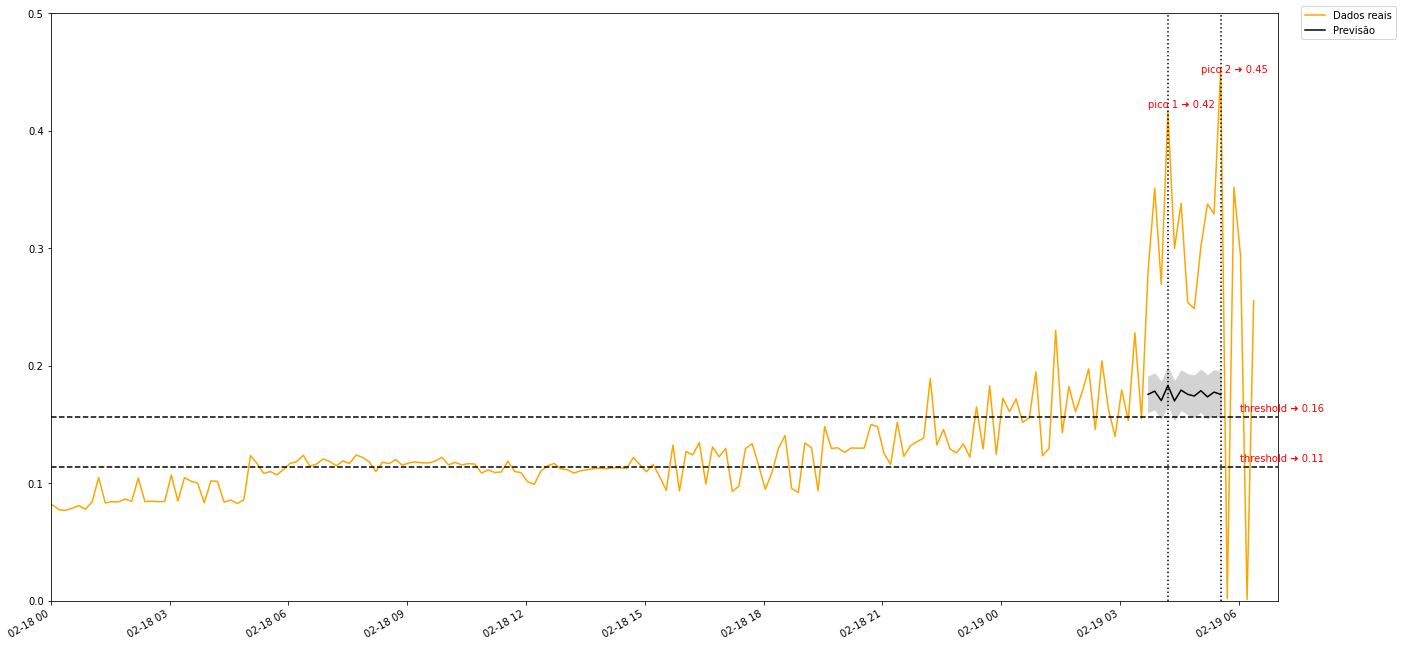

In [49]:
ax = df_rolamento.plot(color='orange')

ax.figure.set_size_inches(22,12)
ax.set_xlabel(None)

ax.set_ylim(0, 0.5)
ax.set_xlim(pd.to_datetime('2004-02-18'),
            pd.to_datetime('2004-02-19 07:00:00'))

pred_uc.predicted_mean.plot(ax=ax, color='k')

ax.fill_between(pred_ic.index,
                pred_ic.iloc[:, 0],
                pred_ic.iloc[:, 1],
                color='lightgrey')

ax.axvline('2004-02-19 04:12:39',
           color='black',
           linestyle=':')

ax.axvline('2004-02-19 05:32:39',
           color='black',
           linestyle=':')

ax.axhline(limite_superior_df,
           color='black',
           linestyle='--')

ax.axhline(lim_sup_df,
           color='black',
           linestyle='--')

ax.annotate(s='threshold ➜ ' + str(lim_sup_df.round(2)),
            xy=(pd.to_datetime('2004-02-19'), lim_sup_df),
            xytext=(pd.to_datetime('2004-02-19 06:02:39'), lim_sup_df + 0.005),
            color='r')

ax.annotate(s='threshold ➜ ' + str(limite_superior_df.round(2)),
            xy=(pd.to_datetime('2004-02-19'), limite_superior_df),
            xytext=(pd.to_datetime('2004-02-19 06:02:39'), limite_superior_df + 0.005),
            color='r')

ax.annotate(s='pico 1 ➜ ' + str(pico_1),
            xy=(pd.to_datetime('2004-02-19'), pico_1),
            xytext=(pd.to_datetime('2004-02-19 03:42:39'), pico_1),
            color='r')

ax.annotate(s='pico 2 ➜ ' + str(pico_2),
            xy=(pd.to_datetime('2004-02-19'), pico_2),
            xytext=(pd.to_datetime('2004-02-19 05:02:39'), pico_2),
            color='r')

ax.legend(labels=['Dados reais', 'Previsão'],
          bbox_to_anchor=(1.1, 1.02))